Implement Edge Attribution Patching

In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
import transformer_lens as tl
from rich.table import Table
from rich import print as rprint
from circuit_finder.pretrained import (
    load_attn_saes,
    load_resid_saes,
    load_hooked_mlp_transcoders,
)
from circuit_finder.core.hooked_transcoder import HookedTranscoderReplacementContext
from circuit_finder.utils import get_answer_tokens, logits_to_ave_logit_diff
from circuit_finder.constants import device, ProjectDir

In [3]:
model = tl.HookedSAETransformer.from_pretrained("gpt2")

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


# Data

In [4]:
from circuit_finder.data_loader import load_datasets_from_json

data_path = ProjectDir / "datasets" / "ioi" / "ioi_vanilla_template_prompts.json"
train_loader, test_loader = load_datasets_from_json(
    model=model,
    path=data_path,
    device=device,
    prepend_bos=True,
    batch_size=8,
    train_test_size=(128, 128),
)

In [5]:
# TODO: Visualize as rich table
for batch in train_loader:
    # print(batch)
    print(model.to_str_tokens(batch.clean[0]))
    print(model.to_str_tokens(batch.answers[0]))
    print(model.to_str_tokens(batch.wrong_answers[0]))
    print(model.to_str_tokens(batch.corrupt[0]))
    break

['<|endoftext|>', 'When', ' Jamie', ' and', ' William', ' went', ' to', ' the', ' station', ',', ' William', ' gave', ' a', ' basketball', ' to']
[' Jamie']
[' William']
['<|endoftext|>', 'When', ' Justin', ' and', ' Emily', ' went', ' to', ' the', ' station', ',', ' Jonathan', ' gave', ' a', ' basketball', ' to']


In [48]:
prompt = ''.join(model.to_str_tokens(batch.clean[0])[1:])
print(prompt)
answer = model.to_str_tokens(batch.answers[0])[0]
tl.utils.test_prompt(prompt, answer, model)

When Jamie and William went to the station, William gave a basketball to
Tokenized prompt: ['<|endoftext|>', 'When', ' Jamie', ' and', ' William', ' went', ' to', ' the', ' station', ',', ' William', ' gave', ' a', ' basketball', ' to']
Tokenized answer: [' Jamie']


Performance on answer token:
Rank: 0        Logit: 16.77 Prob: 65.48% Token: | Jamie|

Top 0th token. Logit: 16.77 Prob: 65.48% Token: | Jamie|
Top 1th token. Logit: 14.36 Prob:  5.92% Token: | the|
Top 2th token. Logit: 13.31 Prob:  2.07% Token: | his|
Top 3th token. Logit: 13.29 Prob:  2.03% Token: | them|
Top 4th token. Logit: 13.22 Prob:  1.89% Token: | a|
Top 5th token. Logit: 13.00 Prob:  1.52% Token: | their|
Top 6th token. Logit: 12.71 Prob:  1.14% Token: | William|
Top 7th token. Logit: 12.58 Prob:  1.00% Token: | one|
Top 8th token. Logit: 11.65 Prob:  0.39% Token: | Patrick|
Top 9th token. Logit: 11.39 Prob:  0.30% Token: | Mary|


Ranks of the answer tokens: [(' Jamie', 0)]

# Models

In [6]:
# Initialize SAEs
attn_saes = load_attn_saes()
for attn_sae in attn_saes.values():
    attn_sae.cfg.use_error_term = True

resid_saes = load_resid_saes()
for resid_sae in resid_saes.values():
    resid_sae.cfg.use_error_term = True

mlp_transcoders = load_hooked_mlp_transcoders()
for mlp_transcoder in mlp_transcoders.values():
    mlp_transcoder.cfg.use_error_term = True

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

# Get Cached Activations

In [7]:
batch = next(iter(train_loader))

In [8]:
import torch
from transformer_lens import ActivationCache

grad_cache_dict = {}


def is_sae_hook(hook_name: str) -> bool:
    return "hook_sae" in hook_name


def backward_cache_hook(act, hook):
    grad_cache_dict[hook.name] = act.detach()


all_saes = list(attn_saes.values()) + list(resid_saes.values())
all_transcoders = list(mlp_transcoders.values())

# Run model
with HookedTranscoderReplacementContext(
    model,  # type: ignore
    transcoders=all_transcoders,
) as context:
    # for wrapped_transcoder in context.wrapped_transcoders:
    #     # NOTE: these will have name 'blocks.8.mlp.hook_sae_XXX'
    #     wrapped_transcoder.add_hook("hook_sae_error", backward_cache_hook, "bwd")
    #     wrapped_transcoder.add_hook("hook_sae_output", backward_cache_hook, "bwd")
    with model.saes(saes = all_saes):
        # Get the corrupt cache
        with torch.no_grad():
            _, corrupt_cache = model.run_with_cache(batch.corrupt)

        # Get the clean cache
        model.reset_hooks()
        model.add_hook(is_sae_hook, backward_cache_hook, "bwd")
        clean_logits, clean_cache = model.run_with_cache(batch.clean)

        # Backpropagate metric
        clean_logit_diff = logits_to_ave_logit_diff(
            clean_logits,  # type: ignore
            batch.answers[:, 0],
            batch.wrong_answers[:, 0],
        )
        clean_logit_diff.backward()
        model.zero_grad()
        model.reset_hooks()

grad_cache = ActivationCache(grad_cache_dict, model)

In [9]:
print(clean_cache)
print(corrupt_cache)
print(grad_cache)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre.hook_sae_input', 'blocks.0.hook_resid_pre.hook_sae_acts_pre', 'blocks.0.hook_resid_pre.hook_sae_acts_post', 'blocks.0.hook_resid_pre.hook_sae_recons', 'blocks.0.hook_resid_pre.hook_sae_error', 'blocks.0.hook_resid_pre.hook_sae_output', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z.hook_sae_input', 'blocks.0.attn.hook_z.hook_sae_acts_pre', 'blocks.0.attn.hook_z.hook_sae_acts_post', 'blocks.0.attn.hook_z.hook_sae_recons', 'blocks.0.attn.hook_z.hook_sae_error', 'blocks.0.attn.hook_z.hook_sae_output', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.transcoder.hook_sae_input', 'blocks.0.mlp.transcoder.hook_sae_acts_pre', 'blocks.0.mlp.transcoder.hook_sae_acts_post

In [10]:
print(grad_cache['blocks.11.mlp.hook_sae_error'][0].norm())

tensor(0.0241, device='cuda:0')


# Node Attribution Patching



In [11]:
# Loop over all SAE errors, outputs

from jaxtyping import Float
from typing import Literal
from dataclasses import dataclass
from transformer_lens import utils

# Node = NamedTuple("Node", [("block", str), ("layer", int), ("hook_type", str)])


@dataclass(frozen=True)
class Node:
    layer: int
    module_name: Literal["mlp", "attn.hook_z", "hook_resid_pre"]
    node_type: Literal["hook_sae_error", "hook_sae_output"]

    @property
    def hook_name(self):
        return f"blocks.{self.layer}.{self.module_name}.{self.node_type}"


nodes = []
for layer in range(12):
    nodes.append(Node(layer, "attn.hook_z", "hook_sae_error"))
    nodes.append(Node(layer, "attn.hook_z", "hook_sae_output"))
    nodes.append(Node(layer, "hook_resid_pre", "hook_sae_error"))
    nodes.append(Node(layer, "hook_resid_pre", "hook_sae_output"))
    nodes.append(Node(layer, "mlp", "hook_sae_error"))
    nodes.append(Node(layer, "mlp", "hook_sae_output"))

## Activation Analysis

In [17]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from einops import rearrange

sns.set_theme()

In [80]:
rows = []

for node_index, node in enumerate(nodes):
    
    clean_activation = clean_cache[node.hook_name]
    if len(clean_activation.shape) == 4:
        clean_activation = rearrange(
            clean_activation, "batch seq n_head d_head -> batch seq (n_head d_head)"
        )

    gradient = grad_cache[node.hook_name]
    if len(gradient.shape) == 4:
        gradient = rearrange(
            gradient, "batch seq n_head d_head -> batch seq (n_head d_head)"
        )

    corrupt_activation = corrupt_cache[node.hook_name]
    if len(corrupt_activation.shape) == 4:
        corrupt_activation = rearrange(
            corrupt_activation, "batch seq n_head d_head -> batch seq (n_head d_head)"
        )

    assert len(clean_activation.shape) == 3

    clean_act: Float[torch.Tensor, "seq d_model"] = clean_activation[0, :, :]
    clean_grad: Float[torch.Tensor, "seq d_model"] = gradient[0, :, :]
    corrupt_act: Float[torch.Tensor, "seq d_model"] = corrupt_activation[0, :, :]

    for token_index in range(n_tok):
        for feature_index in range(n_feat):
            rows.append({
                "layer": node.layer,
                "module_name": node.module_name,
                "node_type": node.node_type,
                "node_index": node_index,
                "token_index": token_index,
                "feature_index": feature_index,
                "clean_act": clean_act[token_index, feature_index].item(),
                "clean_grad": clean_grad[token_index, feature_index].item(),
                "corrupt_act": corrupt_act[token_index, feature_index].item(),
            })


act_df = pd.DataFrame(rows)

In [85]:
act_df['attr'] = act_df['clean_grad'] * (act_df['corrupt_act'] - act_df['clean_act']) 

In [82]:
pd.set_option('display.max_rows', 100)
act_df.sort_values('clean_act', ascending = False).head(100)

,layer,module_name,node_type,node_index,token_index,feature_index,clean_act,clean_grad,corrupt_act
795327,11,hook_resid_pre,hook_sae_output,69,0,447,3050.525879,0.000025,3050.525879
726207,10,hook_resid_pre,hook_sae_output,63,0,447,3046.386963,0.000047,3046.386963
657087,9,hook_resid_pre,hook_sae_output,57,0,447,3033.509521,-0.000094,3033.509521
587967,8,hook_resid_pre,hook_sae_output,51,0,447,3010.037109,0.000028,3010.037109
518847,7,hook_resid_pre,hook_sae_output,45,0,447,2973.039062,-0.000018,2973.039062
449727,6,hook_resid_pre,hook_sae_output,39,0,447,2912.248047,0.000025,2912.248047
380607,5,hook_resid_pre,hook_sae_output,33,0,447,2811.473877,-0.000004,2811.473877
311487,4,hook_resid_pre,hook_sae_output,27,0,447,2659.749268,-0.000100,2659.749268
242367,3,hook_resid_pre,hook_sae_output,21,0,447,2472.257812,0.000023,2472.257812
196287,2,mlp,hook_sae_output,17,0,447,2316.397461,-0.001762,2316.397461


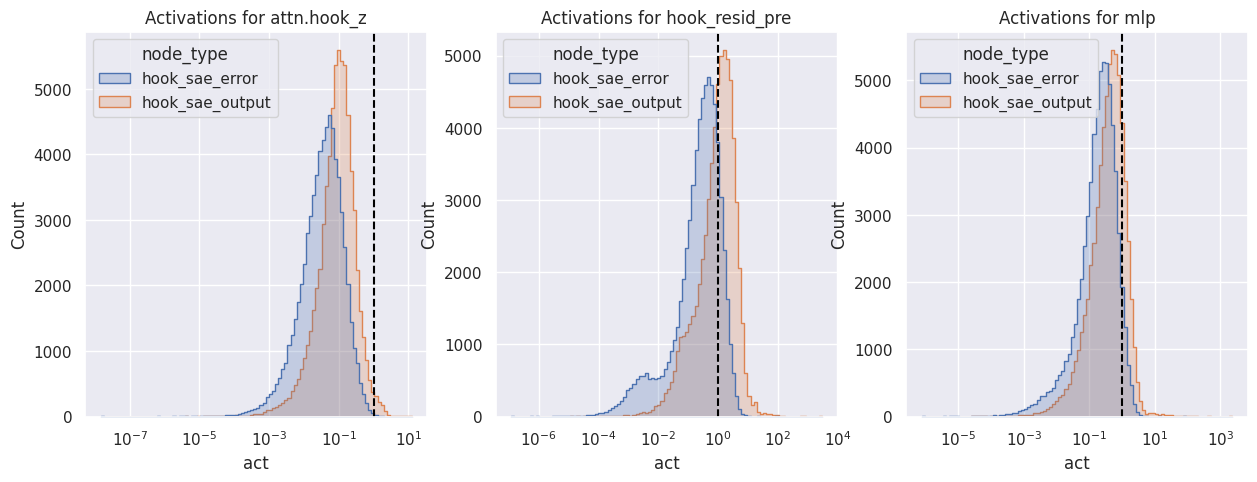

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, module_name in zip(axs, ["attn.hook_z", "hook_resid_pre", "mlp"]):
    sns.histplot(act_df[act_df.module_name == module_name], x = "clean_act", hue = "node_type", bins = 100, common_norm = False, element = "step", ax = ax, log_scale = True)
    ax.set_title(f"Activations for {module_name}")
    ax.axvline(x = 1, ymax = 5000, color='black', linestyle = '--')
fig.show()

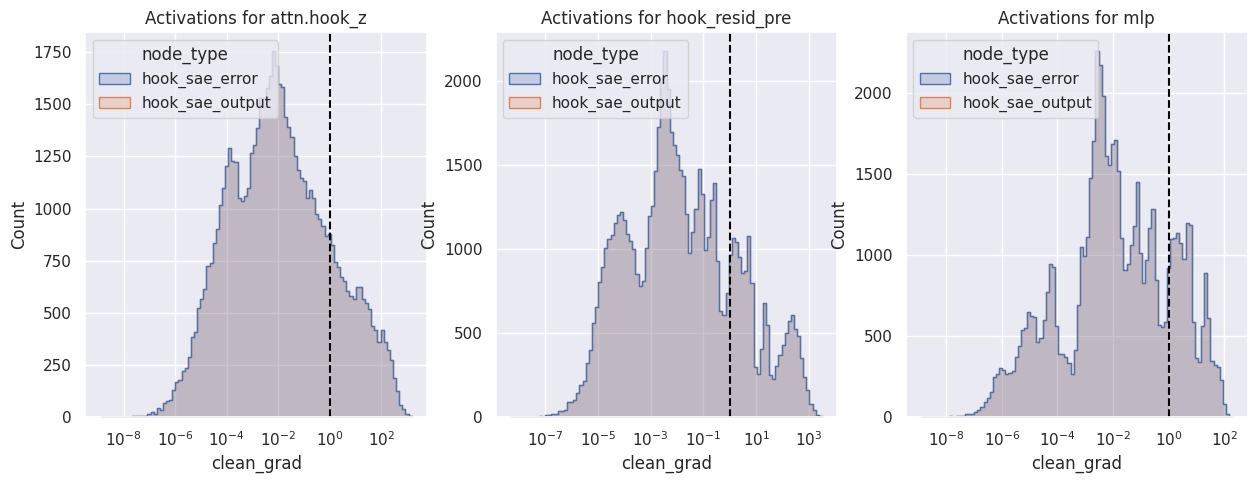

In [83]:
# Plot the gradients
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, module_name in zip(axs, ["attn.hook_z", "hook_resid_pre", "mlp"]):
    sns.histplot(act_df[act_df.module_name == module_name], x = "clean_grad", hue = "node_type", bins = 100, common_norm = False, element = "step", ax = ax, log_scale = True)
    ax.set_title(f"Activations for {module_name}")
    ax.axvline(x = 1, ymax = 5000, color='black', linestyle = '--')
fig.show()

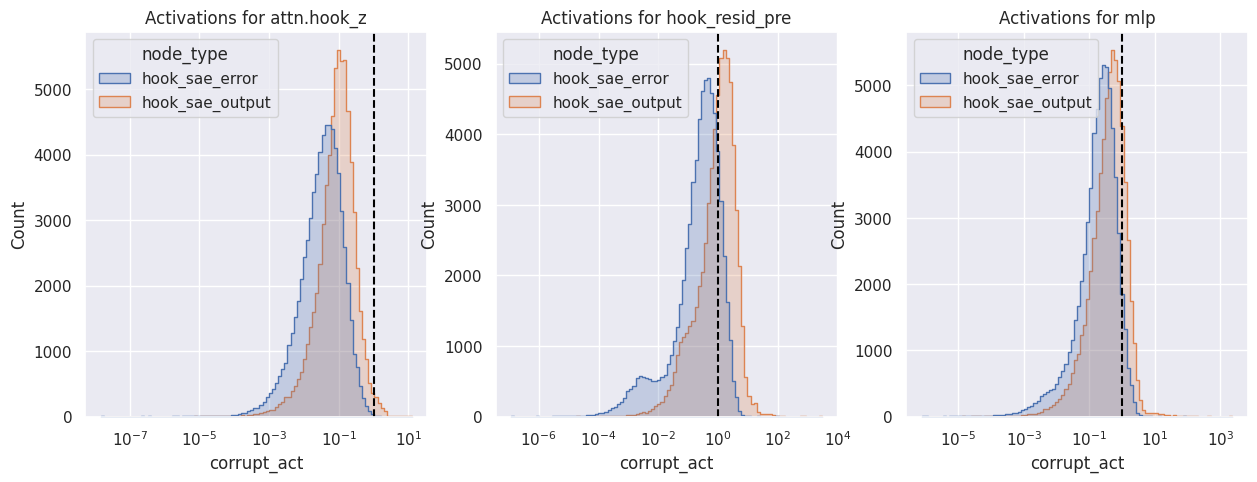

In [84]:
# Plot the gradients
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, module_name in zip(axs, ["attn.hook_z", "hook_resid_pre", "mlp"]):
    sns.histplot(act_df[act_df.module_name == module_name], x = "corrupt_act", hue = "node_type", bins = 100, common_norm = False, element = "step", ax = ax, log_scale = True)
    ax.set_title(f"Activations for {module_name}")
    ax.axvline(x = 1, ymax = 5000, color='black', linestyle = '--')
fig.show()

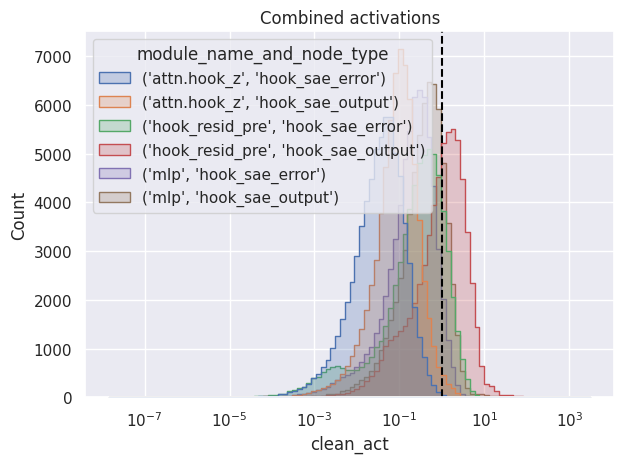

In [94]:
# Combined plot
fig, ax = plt.subplots()

act_df['module_name_and_node_type'] = act_df[['module_name', 'node_type']].apply(tuple, axis = 1)
sns.histplot(act_df, x = "clean_act", hue = "module_name_and_node_type", bins = 100, common_norm = False, element = "step", ax = ax, log_scale = True)
ax.set_title(f"Combined activations")
ax.axvline(x = 1, ymax = 5000, color='black', linestyle = '--')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
fig.show()

## Attribution Analysis

In [98]:
# Calculate the total attribution by layer and node type 
total_attr = act_df.groupby(['layer', 'module_name', 'node_type'])['attr'].sum().reset_index()
total_attr['module_name_and_node_type'] = total_attr[['module_name', 'node_type']].apply(tuple, axis = 1)

<Axes: xlabel='layer', ylabel='attr'>

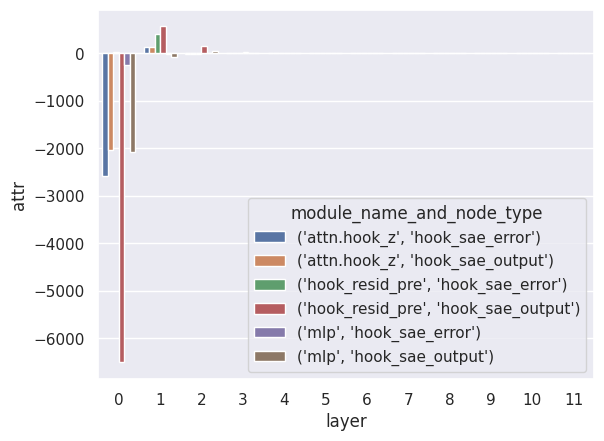

In [99]:
# Plot as barplot
fig, ax = plt.subplots()
sns.barplot(data = total_attr, x = 'layer', y = 'attr', hue = 'module_name_and_node_type', ax = ax)
# ax.set(yscale="log")

Text(0.5, 1.0, 'Total Attribution by Node Type and Layer')

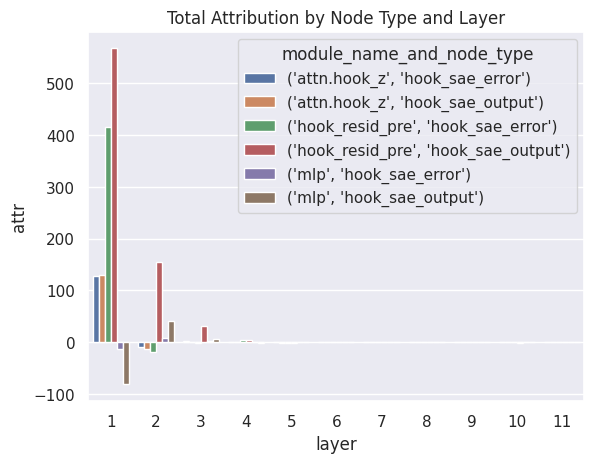

In [102]:
fig, ax = plt.subplots()
sns.barplot(data = total_attr[total_attr.layer >= 1], x = 'layer', y = 'attr', hue = 'module_name_and_node_type', ax = ax)
ax.set_title("Total Attribution by Node Type and Layer")

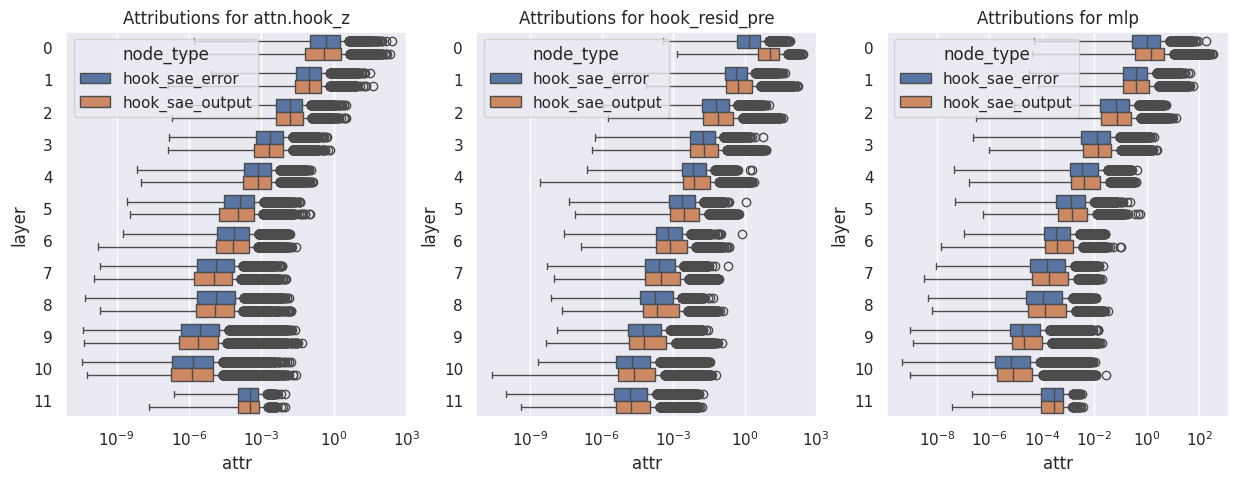

In [86]:
# Plot the attribution of features vs error for each type of node
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, module_name in zip(axs, ["attn.hook_z", "hook_resid_pre", "mlp"]):
    sns.boxplot(
        act_df[(act_df.module_name == module_name) & (act_df['attr'] > 0)],
        x="attr",
        y="layer",
        hue="node_type",
        orient='y',
        ax = ax
    )
    ax.set(xscale="log")
    ax.set_title(f"Attributions for {module_name}")

In [24]:
print(df['attr'].max())

2222.149658203125


In [25]:
print(df.layer.unique())
print(df.module_name.unique())
print(df.node_type.unique())
print(df.node_index.unique())
print(df.token_index.unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11]
['attn.hook_z' 'hook_resid_pre' 'mlp']
['hook_sae_error' 'hook_sae_output']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


(36, 15)
650.4051513671875


<Axes: >

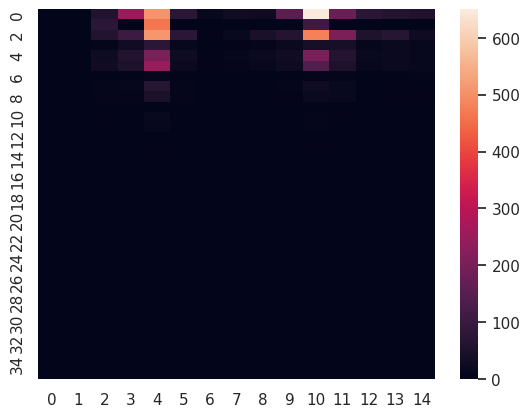

In [29]:
# Construct 2D matrix of node attributions, visualize
import seaborn as sns
import matplotlib.pyplot as plt

attr_np = (
    df[["node_index", "token_index", "attr"]]
    [df.node_type == "hook_sae_error"]
    .pivot(index = "node_index", columns = "token_index", values = "attr")
    .to_numpy()
)
print(attr_np.shape)
print(attr_np.max())
sns.heatmap(attr_np)


(36, 15)
2222.149658203125


<Axes: >

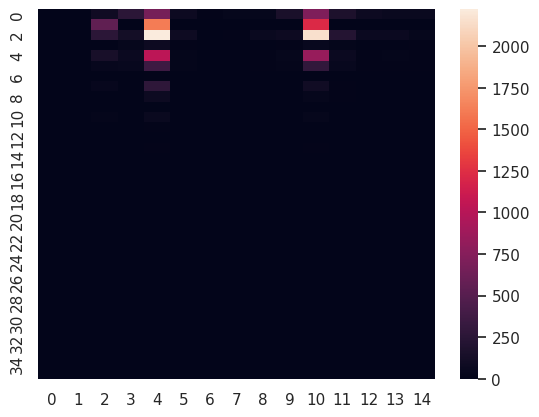

In [30]:
# Construct 2D matrix of node attributions, visualize
import seaborn as sns
import matplotlib.pyplot as plt

attr_np = (
    df[["node_index", "token_index", "attr"]][df.node_type == "hook_sae_output"]
    .pivot(index="node_index", columns="token_index", values="attr")
    .to_numpy()
)
print(attr_np.shape)
print(attr_np.max())
sns.heatmap(attr_np)